In [2]:
import pandas as pd 
import numpy as np
import scipy.stats as stat
import plotly.express as px
import requests
import gzip
import seaborn as sns
from matplotlib.pyplot import gcf
import matplotlib.pyplot as plt

In [190]:
# download data and save as csv, modify column names as described in metadata
# data_url = "https://ftp.ncbi.nlm.nih.gov/geo/datasets/GDS6nnn/GDS6063/soft/GDS6063.soft.gz"
# this data does not belong to me, I use it as an example to create volcano plots
# The data was made available by:
# Dihal AA, van der Woude H, Hendriksen PJ, Charif H et al. 
# Title: Transcriptome and proteome profiling of colon mucosa from quercetin fed F344 rats point 
# to tumor preventive mechanisms, increased mitochondrial fatty acid degradation and decreased glycolysis. 
# Proteomics 2008 Jan;8(1):45-61. PMID: 18095365
# According to authors: The data described in this publication have been deposited in
# NCBIs Gene Expression Omnibus (GEO, http://www.ncbi.nlm.nih.gov/geo)   
# and are accessible throughGEO Series accession numberGSE 7479. 

In [14]:
# read in data 
df = pd.read_csv("../data/GDS3133.csv")
df

,ID_REF,IDENTIFIER,control_1,control_2,control_3,control_4,quercetin_1,quercetin_2,quercetin_3,quercetin_4
0,1367452_at,Sumo2,1733.4400,1215.36000,1658.8700,1599.51000,1750.48000,1217.9900,1482.4600,1531.0900
1,1367453_at,Cdc37,779.5740,756.98800,801.4270,825.54000,818.48100,931.2450,875.9000,877.3290
2,1367454_at,Copb2,2676.4600,3205.87000,2793.1200,2811.09000,2889.69000,2444.8100,2763.0100,2597.1600
3,1367455_at,Vcp,1764.0500,1916.89000,2034.3100,2133.88000,2017.77000,2392.1100,2087.6500,2330.6400
4,1367456_at,Ube2d2,4332.6500,2950.59000,3422.2100,3206.11000,3397.94000,2651.3300,2274.8800,2931.4400
...,...,...,...,...,...,...,...,...,...,...
31094,AFFX_Rat_GAPDH_5_at,Gapdh,7636.6200,1649.12000,4590.1300,5166.38000,4974.95000,5126.7000,4241.4500,5774.6400
31095,AFFX_Rat_GAPDH_M_at,Gapdh,7977.1300,2572.46000,5260.6600,6276.29000,5959.18000,6775.4100,5300.2800,7014.1100
31096,AFFX_Rat_Hexokinase_3_at,Hk1,133.8690,34.04610,60.8851,95.81130,59.89380,71.1572,108.4320,126.4540
31097,AFFX_Rat_Hexokinase_5_at,Hk1,40.9516,12.32910,37.6710,30.84560,25.31340,30.6534,50.2030,20.8916


In [16]:
#variables and functions
color_discrete_map = {'Significant Down': 'firebrick', 
                      'Not Significant Down': 'lightcoral', 
                      'Inconclusive': 'darkgrey', 
                      'Not Significant': 'lightgrey',
                      'Significant Up': 'green',
                      'Not Significant Up': 'lightgreen' 
                    }

def get_p_value(row, cond_1, cond_2):
    ttest_result = stat.ttest_ind(row[cond_1],  row[cond_2])
    return ttest_result[1]

def get_expr(row, pval):
    if (row['log2_FC'] > 0.58) & (row[pval] > 1.3):
        return "Significant Up"
    if (row['log2_FC'] > 0.58) & (row[pval] < 1.3):
        return "Not Significant Up"
    if (row['log2_FC'] < -0.58) & (row[pval] > 1.3):
        return "Significant Down"
    if (row['log2_FC'] < -0.58) & (row[pval] < 1.3):
        return "Not Significant Down"
    if (row['log2_FC'] > -0.58) & (row['log2_FC'] < 0.58) & (row[pval] > 1.3):
        return "Inconclusive"
    else:
        return "Not Significant"

def make_volcano_plot(df, 
                      control_name, 
                      treatment_name,
                      annotation_column, 
                      description_column, 
                      plot_title, 
                      pval):
    
    if pval=='adjusted':
        pval = '-log10_pval_adj'
    elif pval=='unadjusted':
        pval = '-log10_pval'
    
    df = df.set_index([annotation_column, description_column])
    
    cols_control = df.filter(like=control_name).columns.tolist()
    cols_treatment = df.filter(like=treatment_name).columns.tolist()
    
    if len(cols_treatment) <= 1 or len(cols_control) <= 1:
        ValueError("You need more replicates to create a volcano plot")
        
    df["mean_"+control_name] = df[cols_control].mean(axis=1)
    df["mean_"+treatment_name] = df[cols_treatment].mean(axis=1)
            
    df["FC"] = df["mean_"+treatment_name] / df["mean_"+control_name] 
    df["log2_FC"] = np.log2(df["FC"])
    
    
    idx_control = df.columns.get_indexer(cols_control)
    idx_treatment = df.columns.get_indexer(cols_treatment)
    
    df["p_value"] = df.apply(get_p_value, axis=1, args=(idx_control, idx_treatment), )
        
    volcano_df = df[["p_value", "log2_FC"]]          
    volcano_df = volcano_df.dropna() 
    volcano_df["-log10_pval"] = -1*np.log10(volcano_df["p_value"])
    volcano_df["-log10_pval_adj"] = -1*np.log10(len(volcano_df)*volcano_df["p_value"])
    volcano_df["Regulation"] = volcano_df.apply(get_expr, args=(pval, ), axis=1)       
    volcano_df["Regulation"] = volcano_df["Regulation"].astype('category')
        
    volcano_df = volcano_df.reset_index()
    
    sign_up_df = volcano_df.loc[volcano_df["Regulation"] == "Significant Up"].sort_values(by=pval, ascending=False).head(10)
    sign_down_df = volcano_df.loc[volcano_df["Regulation"] == "Significant Down"].sort_values(by=pval, ascending=False).head(10)
    
    labels_df = pd.concat([sign_up_df, sign_down_df], axis=0)
    
    fig = px.scatter(volcano_df, 
                     x='log2_FC', 
                     y=pval,
                     color='Regulation',
                     color_discrete_map=color_discrete_map,
                     hover_data=[annotation_column, description_column],
                     title = plot_title,
                     labels = {"log2_FC": "log2FC(" + treatment_name + "/" + control_name + ")"},
                     template = "simple_white",
                     width=800, height=600)
    
    for i,r in labels_df.iterrows():
        if r['Regulation'] == 'Significant Down':
            color = 'firebrick'
        elif r['Regulation'] == 'Significant Up':
            color = 'green'
        
        fig.add_annotation(x=r['log2_FC'],
                           y=r[pval],
                           text=r[annotation_column], 
                           showarrow=False,
                           xanchor='center',
                           yanchor='bottom',
                           font=dict(size=10, color=color))
    
    fig.add_vline(x=0.58, line_width=2, line_dash="dash", line_color="grey")
    fig.add_vline(x=-0.58, line_width=2, line_dash="dash", line_color="grey")
    fig.add_hline(y=1.3, line_width=2, line_dash="dash", line_color="grey")
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
    fig.update_layout(legend=dict(title=""), title_x=0.5)
    
    #fig.write_html("volcano_plot.html")
    #fig.write_image("volcano_plot.png")
    #fig.write_image("volcano_plot.svg")
    fig.show('png')

    #volcano_df.to_csv('volcano_df.csv')
        
    return 'Complete'


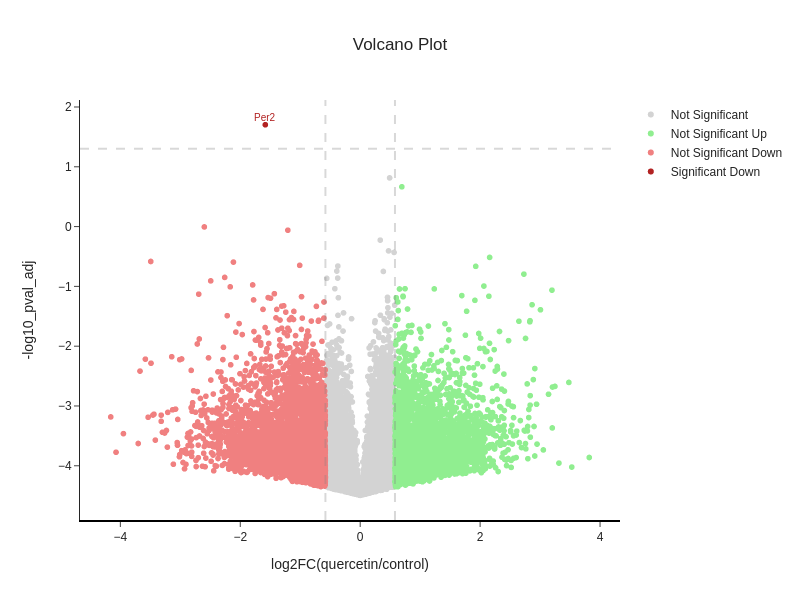

'Complete'

In [17]:
make_volcano_plot(df, 
                  "control", 
                  "quercetin", 
                  "IDENTIFIER", 
                  "ID_REF", 
                  "Volcano Plot", 
                  'adjusted')

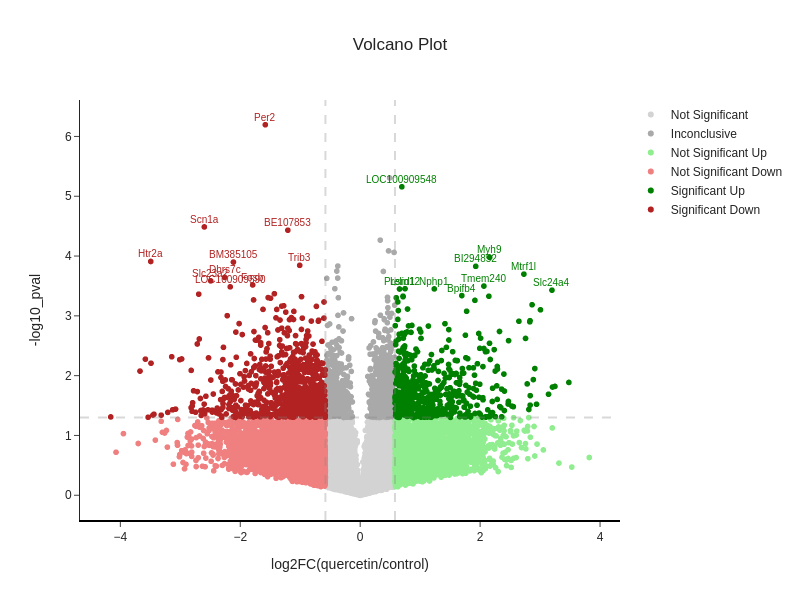

'Complete'

In [18]:
make_volcano_plot(df, 
                  "control", 
                  "quercetin", 
                  "IDENTIFIER", 
                  "ID_REF", 
                  "Volcano Plot", 
                  'unadjusted')